In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [2]:
# We generated a test dataset by sampling from three Gaussians (100 data points each) 
# centered at randomly chosen locations, [(-0.0985, -0.3379), (-0.6325, 0.9322), (1.1078, 1.0856)], 
# with identical covariance matrices 0.04I2, Fig. 3A. 
# Then, we applied Algorithm 1 with the regularization coefficient, lambda = 0.6 
# and found that it correctly clustered the data, Fig. 3A

In [11]:
# Step 1: Generate 3 Gaussians with the given centers & covariances 
x0 = np.random.multivariate_normal(mean = [-0.0985, -0.3379], cov = [[0.04, 0], [0, 0.04]], size = 100)
x1 = np.random.multivariate_normal(mean = [-0.6325, 0.9322], cov = [[0.04, 0], [0, 0.04]], size = 100)
x2 = np.random.multivariate_normal(mean = [1.1078, 1.0856], cov = [[0.04, 0], [0, 0.04]], size = 100)

y0 = []
y1 = []
y2 = []
for i in range(0,100):
    y0.append([0])
    y1.append([1])
    y2.append([2])

X = np.vstack([x0, x1, x2])
y = np.vstack([y0, y1, y2])

indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
y = y.flatten()

In [31]:
np.random.seed(10)
x0 = np.random.normal(0.0, 1.0, [100, 2]) * np.sqrt(0.04) + [-0.0985, -0.3379] # (100, 2)
x1 = np.random.normal(0.0, 1.0, [100, 2]) * np.sqrt(0.04) + [-0.6325,  0.9322] # (100, 2)
x2 = np.random.normal(0.0, 1.0, [100, 2]) * np.sqrt(0.04) + [1.1078,   1.0856] # (100, 2)

y0 = np.array([0] * 100, dtype=np.int32)
y1 = np.array([1] * 100, dtype=np.int32)
y2 = np.array([2] * 100, dtype=np.int32)

X = np.vstack([x0, x1, x2]) # 300, 2
c = np.hstack([y0, y1, y2]) # 300

indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
c = c[indices]

In [32]:
# Sanity Checking y
# y

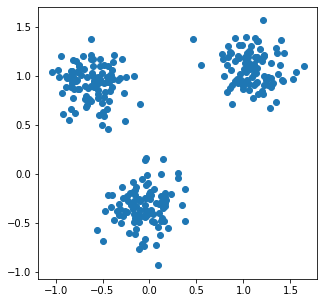

In [33]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1])
plt.show()

In [34]:
# Implement equation 5 (dependency in algorithm)
def adjust_weights(x_t, y_t, index, lamda = 0.6):
    #print("Using equation 5")
    x_squared_norm = np.linalg.norm(x_t)**2
    y_squared = y_t * y_t
    #print(y_t.shape)
    
    test_condition = (x_squared_norm - np.sum(y_squared) + y_squared[index])
    
    if((test_condition ** 2) <= lamda):
        return 0
    else:
        if(test_condition < 0):
            return 0
        else:
            return np.sqrt(test_condition)
    

In [35]:
# Implement equation 8 (dependency in algorithm)
def update_weights(W, M, x_t, y_t, y_hat):
    #y_hat += (y_t * y_t)
    #print("Using equation 8")
    y_dim = y_t.shape[0]
    
    x_t = x_t[np.newaxis, :]
    y_t = y_t[:, np.newaxis]
    
    dW = y_t @ (x_t - (W.T @ y_t).T)
    
    
    for i in range(ydim):
        if(y_hat[i] !=0):
            W[i] = W[i] + dW[i] / y_hat[i]
    
    dM = y_t @ (y_t.T - (M @ y_t).T)
    for i in range(M.shape[0]):
        dM[i][i] = 0
    
    for i in range(ydim):
        if(y_hat[i] !=0):
            M[i] = M[i] + dM[i] / y_hat[i]
    
    

Algorithm 1: Online SNMF <br>
Start with the empty active set {}, W’ = 0 and M = 0. <br> 
For each T=1...Tf
    1. Initialize yT = 0.
    2. Receive xT.
    3. For each degree of freedom in the active set {i}
    compute yT ,i = maxWT ,i xT  MT ,i yT ,0iterating
    until convergence.
    4. If required by (5) add another degree of freedom to
    the active set {i}.
    5. Output yT.
    6. Update “synaptic connections” W’ and M
    according to (8).

In [36]:
T = X.shape[0]
ydim = 3 #From the SNMF Ref. code -- perhaps for number of classes? 
active_set = []
ith_degree_used = np.zeros(ydim)
W = np.zeros((ydim, X.shape[1]))
M = np.zeros((ydim, ydim))

y_hat = np.zeros(ydim) 

clusters = []

iterations = 100

for t in range(T): 
    x_t = X[t] 
    y_t = np.zeros(ydim) 
    #One-hot encoded (sort of - soft encoding not binary) 
    #  element Yt,i is non-zero if sample t is attributed to cluster i. --Quote from paper
    #Should scaling factor from eqn 3 be included? 
    for i in active_set:
        #Iterate till convergence -- convergence criteria not mentioned in paper for this algorithm
        #Ref. Code takes it as 100 steps? 
        for itr in range(iterations): 
            y_ti = max(0, (W[i] @ x_t - M[i] @ y_t))
        y_t[i] = y_ti
        
#     for j in range(ydim):
#         if ith_degree_used[j] == 0:
#             y_t[j] = adjust_weights(x_t, y_t, j)
                
#     for j in range(ydim):
#         if y_t[j] != 0.0:
#             ith_degree_used[j] += 1
            
#     for j in range(ydim):
#         if (j not in active_set) and ith_degree_used[j] > 0:
#             active_set.append(j)
        
    
    
    for j in range(ydim):
        if ith_degree_used[j] == 0:
            y_t[j] = adjust_weights(x_t, y_t, j)
            #y_t[j] = adjust_y_i(y_t, x_t, j)
            
    for j in range(ydim):
        #Check all degrees of freedom
        #So far, this degree of freedom has not been used, then adjust weights by eqn 5;
        if(ith_degree_used[j] == 0):  
            y_t[j] = adjust_weights(x_t, y_t, j)
            #y_t[j] = adjust_y_i(y_t, x_t, j)
            #active_set.append(j)
        if(y_t[j]!=0):
            ith_degree_used[j] = ith_degree_used[j] + 1
        if(j not in active_set and ith_degree_used[j] > 0):
                active_set.append(j)
    
    print(active_set)
    #Now, update weights as per eqn 8
    y_hat = y_hat + y_t * y_t #DIFFERENT FROM ORIGINAL IMPLEMENTATION but makes sense to me? 
    #update_weight(W, M, x_t, y_t, y_hat)
    update_weights(W, M, x_t, y_t, y_hat)
      
    cluster = np.argmax(y_t)
    #if(cluster == 2):
    #    print(i+1)
    #print(cluster)
    clusters.append(cluster)

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0

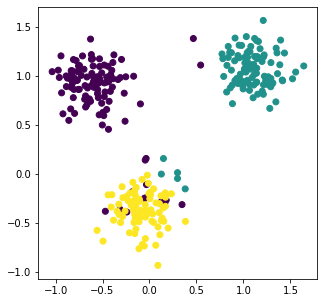

In [37]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

In [ ]:
W.T.shape

In [ ]:
x_t.shape

In [ ]:
y_t.shape

In [ ]:
W.T

In [ ]:
x_t[np.newaxis,:].shape

In [ ]:
x_t

In [ ]:
x_t.shape

In [ ]:
    x_t = x_t[np.newaxis, :]
    y_t = y_t[:, np.newaxis]

In [ ]:
y_t@(M@y_t).T

In [ ]:
x_t.shape

In [ ]:
y_t.shape

In [ ]:
W.shape

In [ ]:
W.T.shape

In [ ]:
W.T @ y_t

In [ ]:
y_t @ x_t

In [ ]:
y_t @ W.T @ y_t

In [ ]:
y_t.shape

In [ ]:
W.T.shape

In [ ]:
dW.shape

In [ ]:
y_t